In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [6]:
xray_imgs = "/content/drive/MyDrive/MIT FutureMakers/Day 17/Data"

In [15]:
!ls "$xray_imgs"

COVID  Non-COVID


In [16]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    xray_imgs,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    xray_imgs,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 3673 files belonging to 2 classes.
Using 2939 files for training.
Found 3673 files belonging to 2 classes.
Using 734 files for validation.


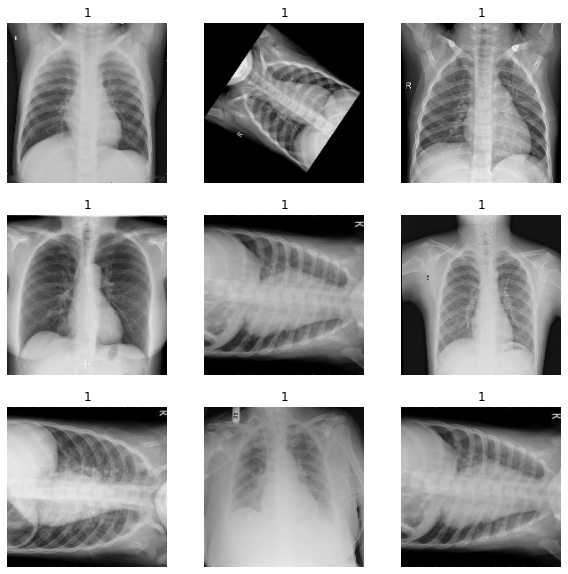

In [18]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [19]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

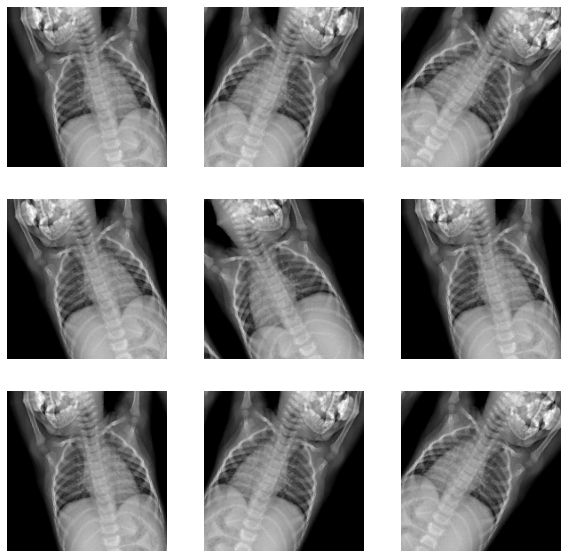

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [21]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

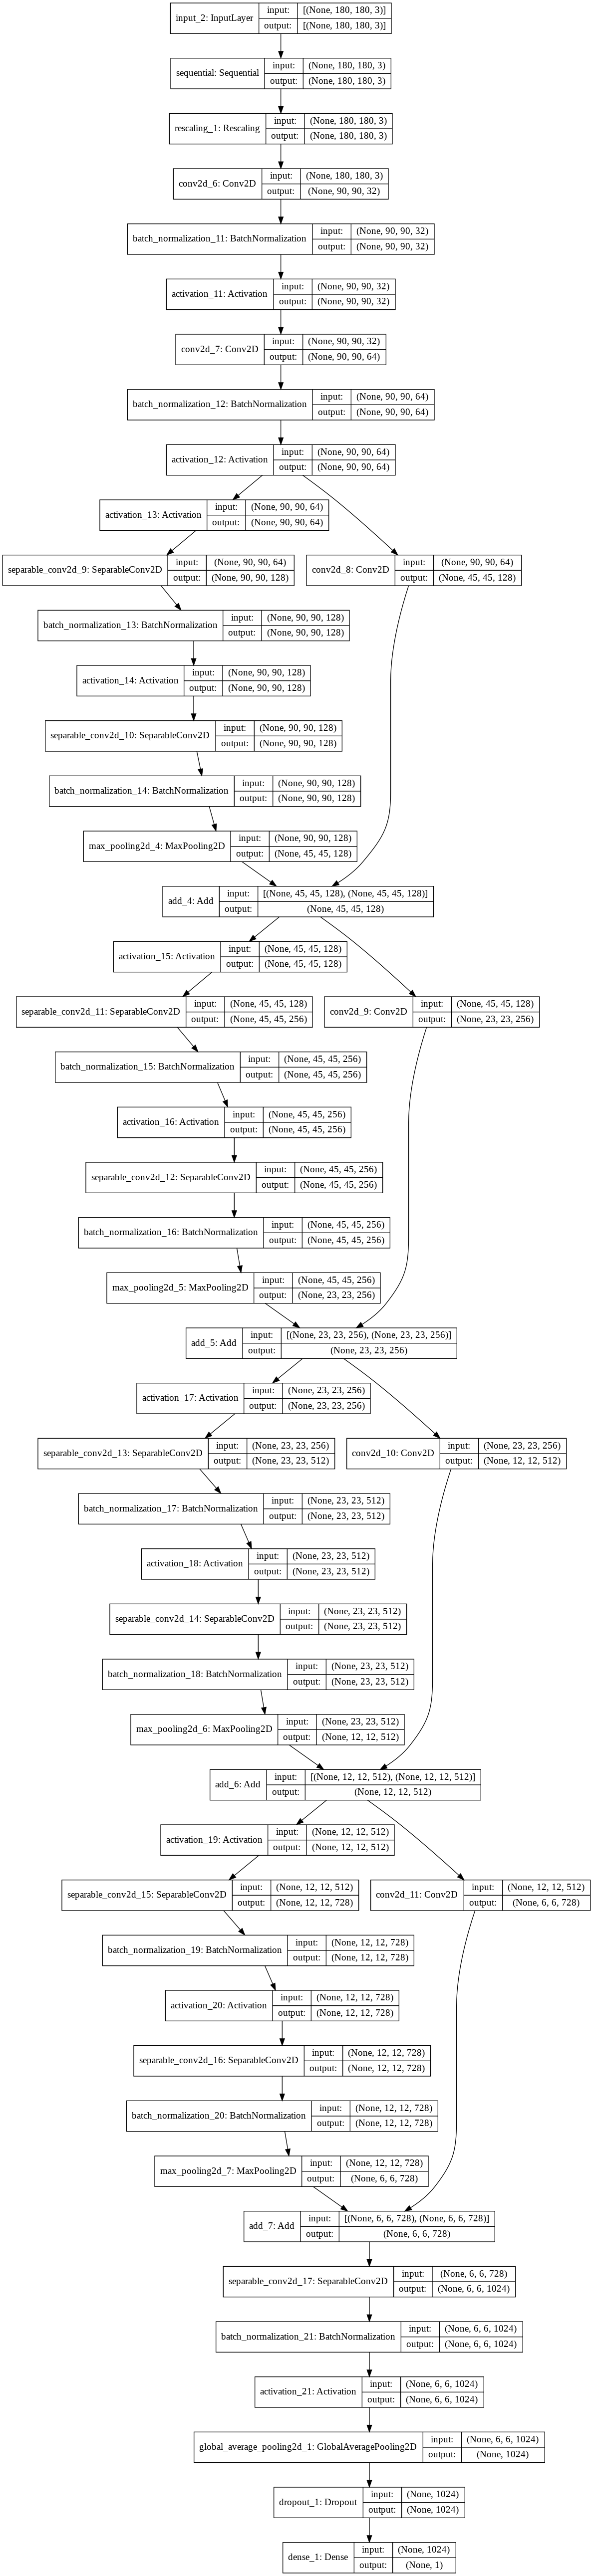

In [23]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = data_augmentation(inputs)

    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual]) 
        previous_block_activation = x 

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
92/92 [==============================] - 1091s 12s/step - loss: 0.1600 - accuracy: 0.9473 - val_loss: 0.3980 - val_accuracy: 0.9728


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
92/92 [==============================] - 730s 8s/step - loss: 0.1230 - accuracy: 0.9636 - val_loss: 0.3158 - val_accuracy: 0.9728
Epoch 3/50
92/92 [==============================] - 730s 8s/step - loss: 0.1139 - accuracy: 0.9622 - val_loss: 0.5118 - val_accuracy: 0.9755
Epoch 4/50
92/92 [==============================] - 727s 8s/step - loss: 0.1056 - accuracy: 0.9616 - val_loss: 0.3451 - val_accuracy: 0.9728
Epoch 5/50
92/92 [==============================] - 730s 8s/step - loss: 0.1058 - accuracy: 0.9612 - val_loss: 0.2718 - val_accuracy: 0.9823
Epoch 6/50
92/92 [==============================] - 732s 8s/step - loss: 0.1009 - accuracy: 0.9626 - val_loss: 0.1883 - val_accuracy: 0.9741
Epoch 7/50
92/92 [==============================] - 734s 8s/step - loss: 0.0970 - accuracy: 0.9619 - val_loss: 0.0658 - val_accuracy: 0.9768
Epoch 8/50
92/92 [==============================] - 740s 8s/step - loss: 0.0864 - accuracy: 0.9670 - val_loss: 0.1546 - val_accuracy: 0.9578
Epoch 9/50
92